# Part 1: Collecting the data
## 1) Commits
### Retrieving the logs
Use git and hg logs to export commits for various projects.
* For mercurial, it's `hg log --no-merges --user "<username>"`
* For git, it's `git log --no-merges --author=<username>`

### Processing the logs
First, let's parse the git logs.

In [40]:
import sys
from dateutil.parser import parse
import datetime

commit_ids = []
dates = []
messages = []
for j in range(1, 4):
    path='data/git_commit' + str(j) + '.txt'
    f = open(path, 'r')
    index = 0
    for line in f:
        index += 1
        if(index % 6 == 1):
            commit_ids.append(line.split(' ')[-1][:-1])
        if(index % 6 == 3):
            date = line[8:-7]
            #from 'Wed Nov 2 13:00:17 2016' to '2016-11-02'
            formatted_date = datetime.datetime.strptime(date, '%a %b %d %H:%M:%S %Y').strftime('%Y-%m-%d')
            dates.append(formatted_date)
        if(index % 6 == 5):
            messages.append(line[:-1])
    g = open(path[:-4]+'_output.tsv', 'w')
    for i in range(0, len(commit_ids)):
        g.write(commit_ids[i] + '\t' + dates[i] + '\t' + messages[i] + '\n')

Next, let's move on to hg logs.

In [ ]:
commit_ids = []
dates = []
messages = []
for j in range(1, 4):
    path='data/hg_commit' + str(j) + '.txt'
    f = open(path, 'r')
    for line in f:
        if(line.startswith('changeset:')):
            commit_ids.append(line.split(' ')[-1][:-1])
        if(line.startswith('date:')):
            date = line[13:-7]
            #from 'Wed Feb 11 13:16:31 2015' to '2015-02-11'
            formatted_date = datetime.datetime.strptime(date, '%a %b %d %H:%M:%S %Y').strftime('%Y-%m-%d')
            dates.append(formatted_date)
        if(line.startswith('summary:')):
            messages.append(line[:-1])
    g = open(path[:-4]+'_output.tsv', 'w')
    for i in range(0, len(commit_ids)):
        g.write(commit_ids[i] + '\t' + dates[i] + '\t' + messages[i] + '\n')

## 2) Tasks
### Teamwork
Teamwork allows you to export task logs into excel.

## 3) Messages
### Skype
Skype creates a local database on the client machine. On macs, it's located at:

`/Users/<username>/Library/Application\ Support/Skype/<skype_username>/main.db`.

To read the database:
* Install sqlite
* `$ sqlite3 /path/to/main.db`
* Then type:
````
sqlite> .headers off
sqlite> .mode csv
sqlite> .output messages.csv
sqlite> SELECT id, convo_id, timestamp, type, author FROM Messages WHERE author='<skype_username>';
sqlite> .quit
````

This will give you a csv file which can be parsed using python.

In [ ]:
f = open('data/messages.csv', 'r')
g = open('data/skype.tsv', 'w')
for line in f:
    sline = line.split(',')
    id = sline[0]
    conv_id = sline[1]
    ts = sline[2]
    date = datetime.datetime.fromtimestamp(int(ts)).strftime('%Y-%m-%d')
    g.write(id + '\t' + conv_id + '\t' + date + '\n')

### Slack
To export your message history from Slack, you will need a to be an admin. Otherwise, an admin needs to grant you the right to create an access token.  

First, I found all of the channel ids where I was a member, using the `channels.list` method. Then, I repeated the same process for all of the private channels (which slack calls *groups*).

In [ ]:
import requests
import json
my_user_id = '<my_user_id>'
my_access_token = '<my_access_token>'

def is_member(j):
    return j['is_member']

def map_ids(j):
    return (j['name'], j['id'])

channels_list_resp = requests.get("https://slack.com/api/channels.list?token={}".format(my_access_token))
all_channels = channels_list_resp.json()['channels']

member_channels = list(map(map_ids, list(filter(is_member, all_channels))))
print(member_channels)

groups_list_resp = requests.get("https://slack.com/api/groups.list?token={}".format(my_access_token))
all_groups = groups_list_resp.json()['groups']

member_groups = list(map(map_ids, all_groups))
print(member_groups)

Next, I found my message history in each of the channels I had been a member in, using the `channels.history` method. Then I filtered the channel by my own messages, and extracted the timestamp and text of each message.

In [ ]:
def my_messages(j):
    return j['user'] == my_user_id

g = open('data/slack_output.tsv', 'w')
for j in member_channels:
    channel_history_resp = requests.get("https://slack.com/api/channels.history?token={}&channel={}".format(my_access_token, j[1]))
    channel_history = channel_history_resp.json()['messages']
    my_history = list(filter(my_messages, channel_history))
    for m in my_history:
        g.write(m['ts'] + '\t' + datetime.datetime.fromtimestamp(float(m['ts'])).strftime('%Y-%m-%d') + '\t' + m['text'].replace('\n', ' ').replace('\t', ' ') + '\t' + j[0] + '\n')
    
for j in member_groups:
    channel_history_resp = requests.get("https://slack.com/api/groups.history?token={}&channel={}".format(my_access_token, j[1]))
    channel_history = channel_history_resp.json()['messages']
    my_history = list(filter(my_messages, channel_history))
    for m in my_history:
        g.write(m['ts'] + '\t' + datetime.datetime.fromtimestamp(float(m['ts'])).strftime('%Y-%m-%d') + '\t' + m['text'].replace('\n', ' ').replace('\t', ' ') + '\t' + j[0] + '\n')
g.close()

## 4) Documents created and edited

### Google Drive
The web interface provides an acitivty log for all files and folders. Since I keep all work-related documents in a separate folder, I found it relatively easy to manually copy and parse the logs using python. 

In [ ]:
f = open('data/gdrive.txt', 'r')
g = open('data/gdrive_output.tsv', 'w')
lines = f.read().splitlines()
i = -1
while(i < len(lines)-1):
    i += 1
    if(lines[i].startswith('You') and len(lines[i+1]) == 12 and not lines[i+1].endswith(' AM') and not lines[i+1].endswith(' PM')):
        date = lines[i+1]
        formatted_date = datetime.datetime.strptime(date, '%b %d, %Y').strftime('%Y-%m-%d')
        g.write(formatted_date + '\t' + lines[i] + '\n')
    

### Hub
The hub doesn't allow you to access your acitivty logs, but you can see the content you're created or participated in, and the last edit timestamp. If copied into a text file, it's easy to parse.

In [ ]:
f = open('data/hub.txt', 'r')
g = open('data/hub_output.tsv', 'w')
for line in f:
    sline = line.split('\t')
    if(len(sline) > 2):
        d = sline[1]
        if(d.endswith(' AM') or d.endswith(' PM')):
            #from 'October 13, 2016 10:08 AM' to '2016-10-13'
            formatted_date = datetime.datetime.strptime(d, '%B %d, %Y %H:%M %p').strftime('%Y-%m-%d')
            g.write(formatted_date + '\n')

## 5) Email Messages
Outlook 2016 for mac provides a sqlite database that can be queried directly (similar to how I processed Skype messages). But Outlook 2011 for mac has very limited options for automated access. The messages are archived as "olk14MsgSource" files, where the message body and most metadata is encrypted. 

Even though it's not impossible to work with the "olk14MsgSource" files, I opted to work with a better option. The only export option provided by the client is Microsoft's proprietary ".olm" format.

Thankfully, [StuffIt Expander](http://my.smithmicro.com/stuffit-expander-mac.html) is able to extract the .olm archive and organize it into xml files. I parsed the xml files to extract the timestamp of my sent items.

In [ ]:
import xml.etree.ElementTree as ET
import os  
import datetime

dirp = 'data/Sent_Items/'
g = open('data/Sent_Items_output.tsv', 'w')
for fn in os.listdir(dirp):
    if(fn.endswith('.xml')):
        tree = ET.parse(dirp + fn)
        root= tree.getroot()
        for r in root.iter('emails'):
            for e in root.iter('email'):
                d = e.find('OPFMessageCopySentTime')
                if(d != None):
                    dt = d.text
                    g.write(dt[0:10] + '\t' + dt[11:] + '\n')
g.close()

## 6) Calendar Events
Similar to Email Messages, I extracted calendar events using StuffIt. The catch with the calendar xml is that it only marks recurring events once. For recurring events to count every time they take place, I had to write a function that replicated their repetitions. I also opted to ignore all-day events, since they often referred to vacation notices, or  company workshops/seminars.

In [ ]:
# timezone extraction functions
def extract_time_zone_diff(tz):
    stz = tz.split("(")[1].split(")")[0]
    sstr_minus = stz.split("-")
    sstr_plus = stz.split("+")
    if(len(sstr_minus) > 1):
        return int(sstr_minus[1].split(':')[0]) * -60
    if(len(sstr_plus) > 1):
        return int(sstr_plus[1].split(':')[0]) * 60
    return 0

def convert_to_EST_diff(tz):
    return -300 - extract_time_zone_diff(tz)

convert_to_EST_diff('(UTC-02)')

In [ ]:
# timezone adjustment functions
def convert_datetime(dt, delta):
    d = datetime.datetime.strptime(dt, '%Y-%m-%dT%H:%M:%S')
    new_d = d + datetime.timedelta(minutes = delta)
    return new_d.strftime('%Y-%m-%dT%H:%M:%S')

convert_datetime('2013-12-18T10:30:00', convert_to_EST_diff('(UTC-02)'))

In [ ]:
# given a meeting's start and end time, calculate its duration in minutes
def calculate_duration(st, et):
    d1 = datetime.datetime.strptime(st, '%Y-%m-%dT%H:%M:%S')
    d2 = d = datetime.datetime.strptime(et, '%Y-%m-%dT%H:%M:%S')
    return int((d2 - d1).total_seconds() / 60)

calculate_duration('2013-12-18T20:30:00', '2013-12-18T21:30:00')

In [ ]:
# repetition simulation functions
from dateutil.relativedelta import relativedelta

def get_proper_delta(r_t):
    if(r_t == 'OPFRecurrencePatternDaily'):
        return relativedelta(days = +1)
    if(r_t == 'OPFRecurrencePatternWeekly'):
        return relativedelta(weeks = +1)
    if(r_t == 'OPFRecurrencePatternRelativeMonthly'):
        return relativedelta(months = +1)

def get_repeated_events(tree, date, st, et, organizer, summary, count, duration):
    output = ''
    r = tree.find('OPFCalendarEventCopyRecurrence')
    if(r != None):
        # find the last day of recurrence for the event
        end_date = '2017-01-08T00:00:00'
        ends = r.find('OPFRecurrenceHasEndDate')
        if(ends != None and ends.text == '1' ):
            last_day = r.find('OPFRecurrenceCopyEndDate').text
            if(last_day != '2001-01-01T00:00:00'): 
                end_date = last_day
        end_day = datetime.datetime.strptime(end_date, '%Y-%m-%dT%H:%M:%S')
        first_day = datetime.datetime.strptime(date, '%Y-%m-%d')
        # find the repetition pattern  
        r_type = r.find('OPFRecurrencePattern').find('OPFRecurrencePatternType').text
        curr_day = first_day + get_proper_delta(r_type)
        while(curr_day <= end_day):
                output += create_line(organizer, summary, datetime.datetime.strftime(curr_day, '%Y-%m-%d'), st, et, str(count), str(duration)) 
                curr_day += get_proper_delta(r_type)
    return output

tree = ET.parse('data/Calendar.xml')
root= tree.getroot()
for app in root.iter('appointment'):
    if(app.find('OPFCalendarEventCopyRecurrence') != None):
        organizer = app.find('OPFCalendarEventCopyOrganizer').text
        summary = (app.find('OPFCalendarEventCopySummary').text if app.find('OPFCalendarEventCopySummary') != None else '').strip()
        time_zone = app.find('OPFCalendarEventCopyTimeZone').text
        start_time = convert_datetime(app.find('OPFCalendarEventCopyStartTime').text, convert_to_EST_diff(time_zone))
        end_time = convert_datetime(app.find('OPFCalendarEventCopyEndTime').text, convert_to_EST_diff(time_zone))
        date = start_time[0:10]
        st = start_time[11:] 
        et = end_time[11:]
        count = 1
        duration = calculate_duration(start_time, end_time)
        get_repeated_events(app, date, st, et, organizer, summary, count, duration)

In [ ]:
# main Calendar xml parser

def create_line(organizer, summary, date, st, et, count, duration):
    return organizer + '\t' + 
            summary + '\t' + 
            date + '\t' + 
            st + '\t' + 
            et + '\t' + 
            str(count) + '\t' +
            str(duration) + '\n'

g = open('data/Calendar_output.tsv', 'w')
tree = ET.parse('data/Calendar.xml')
root= tree.getroot()
repetitions = ''
for app in root.iter('appointment'):
    # extract timezone
    organizer = app.find('OPFCalendarEventCopyOrganizer').text
    summary = (app.find('OPFCalendarEventCopySummary').text if app.find('OPFCalendarEventCopySummary') != None else '').strip()
    time_zone = app.find('OPFCalendarEventCopyTimeZone').text
    start_time = convert_datetime(app.find('OPFCalendarEventCopyStartTime').text, convert_to_EST_diff(time_zone))
    end_time = convert_datetime(app.find('OPFCalendarEventCopyEndTime').text, convert_to_EST_diff(time_zone))
    date = start_time[0:10]
    st = start_time[11:] 
    et = end_time[11:]
    count = 1
    duration = calculate_duration(start_time, end_time)
    # get rid of all-day events
    if(duration < 1440):
        g.write(create_line(organizer, summary, date, st, et, str(count), str(duration)))
        if(app.find('OPFCalendarEventCopyRecurrence') != None):
            repetitions += get_repeated_events(app, date, st, et, organizer, summary, count, duration)
g.write(repetitions)
g.close()

# Part 2) Visualizing the data
I loaded all of the '\_output.tsv' files into a google spreadsheet, drew a pivot table, and charted it using a color-code system for each workstream. This could have been done using python as well, but I found it more convenient to use gdocs. From here on, the data can be loaded into objects and analyzed in detail.     

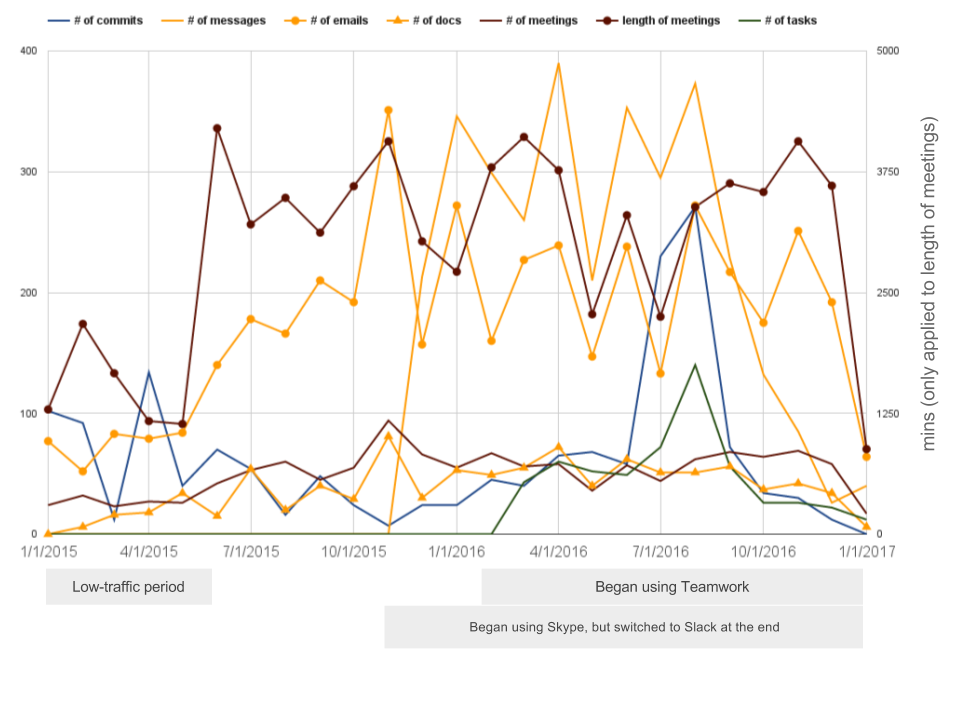

In [16]:
from IPython.display import Image
Image("data/Chart.png")

Lastly, I loaded the email dataset and created a word cloud of subject terms: 

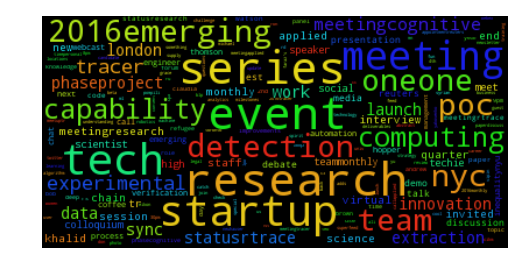

In [50]:
from wordcloud import WordCloud

f = open("data/Calendar_output.tsv", 'r')
lines = f.read().splitlines()
text = ''
start_date = datetime.datetime.strptime('2016-03-18', '%Y-%m-%d')
for line in lines:
    date = datetime.datetime.strptime(line.split('\t')[2], '%Y-%m-%d') 
    if(date > start_date):
        text += line.split('\t')[1].lower()

wordcloud = WordCloud().generate(text)

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
f = plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
f.savefig('data/wordcloud.jpg')